# Rascunho

In [1]:
import numpy as np
import pystan as ps
import sympy as sp
import networkx as nx

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import arviz as az
import seaborn as sns
sns.set()

from scipy.special import expit, logit

%matplotlib inline

import pickle

import sys
sys.path.append('../scripts/')

from utilits import ParameterAlpha, BivariateBeta

In [2]:
compiled = True
#compiled = False

if compiled: 
    sm1 = pickle.load(open('../models/extra/sketch-v1.pkl', 'rb'))
else: 
    sm1 = ps.StanModel(file = '../models/extra/sketch-v1.stan')
    with open('../models/extra/sketch-v1.pkl', 'wb') as f:
        pickle.dump(sm1, f)
        
compiled = True
#compiled = False

if compiled: 
    sm2 = pickle.load(open('../models/extra/sketch-v2.pkl', 'rb'))
else: 
    sm2 = ps.StanModel(file = '../models/extra/sketch-v2.stan')
    with open('../models/extra/sketch-v2.pkl', 'wb') as f:
        pickle.dump(sm2, f)
        
compiled = True
#compiled = False

if compiled: 
    sm3 = pickle.load(open('../models/extra/sketch-v3.pkl', 'rb'))
else: 
    sm3 = ps.StanModel(file = '../models/extra/sketch-v3.stan')
    with open('../models/extra/sketch-v3.pkl', 'wb') as f:
        pickle.dump(sm3, f)
        
compiled = True
#compiled = False

if compiled: 
    sm4 = pickle.load(open('../models/extra/sketch-v4.pkl', 'rb'))
else: 
    sm4 = ps.StanModel(file = '../models/extra/sketch-v4.stan')
    with open('../models/extra/sketch-v4.pkl', 'wb') as f:
        pickle.dump(sm4, f)

compiled = True
#compiled = False

if compiled: 
    sm5 = pickle.load(open('../models/extra/sketch-v5.pkl', 'rb'))
else: 
    sm5 = ps.StanModel(file = '../models/extra/sketch-v5.stan')
    with open('../models/extra/sketch-v5.pkl', 'wb') as f:
        pickle.dump(sm5, f)
        
compiled = True
#compiled = False

if compiled: 
    sm6 = pickle.load(open('../models/extra/sketch-v6.pkl', 'rb'))
else: 
    sm6 = ps.StanModel(file = '../models/extra/sketch-v6.stan')
    with open('../models/extra/sketch-v6.pkl', 'wb') as f:
        pickle.dump(sm6, f)
        
compiled = True
#compiled = False

if compiled: 
    sm7 = pickle.load(open('../models/extra/sketch-v7.pkl', 'rb'))
else: 
    sm7 = ps.StanModel(file = '../models/extra/sketch-v7.stan')
    with open('../models/extra/sketch-v7.pkl', 'wb') as f:
        pickle.dump(sm7, f)
        
compiled = True
#compiled = False

if compiled: 
    sm8 = pickle.load(open('../models/extra/sketch-v8.pkl', 'rb'))
else: 
    sm8 = ps.StanModel(file = '../models/extra/sketch-v8.stan')
    with open('../models/extra/sketch-v8.pkl', 'wb') as f:
        pickle.dump(sm8, f)

In [8]:
n = 100
p = 10

X = np.random.multivariate_normal(mean = np.zeros(p+1),
                                  cov = np.eye(p+1), 
                                  size = n)
X = (X - X.mean(axis = 0))/X.std(axis = 0)
X[:,0] = 1

#W = nx.adjacency_matrix(nx.generators.trees.random_tree(n = n)).toarray()
W = nx.adjacency_matrix(nx.random_graphs.erdos_renyi_graph(n = n, p = 1/n)).toarray()
for i in range(n):
    if sum(W[i,:]) == 0:
        j = np.random.choice([k for k in range(n) if k != i])
        W[i,j] = 1
        W[j,i] = 1
        
W_n = W.sum() // 2
D = np.diag(W.sum(axis = 1))

rho = 0.5
tau = 0.001
prev  = 0.2
beta = np.array([logit(prev), -1.5, 0.4, 1, 0, 0.3, -0.8, 2, 0.9, 1.3, -1.93])

phi = np.random.multivariate_normal(mean = np.zeros(n), 
                                    cov = (1/tau) * np.linalg.inv(D - rho * W))

y = np.random.binomial(n = 1, p = expit(phi + X @ beta))
#y = np.random.poisson(np.exp(logit(prev) + phi + log_offset))

mu_beta = np.zeros(p+1)
mu_beta[0] = -2.7

cov_beta = np.eye(p+1)
cov_beta[0,0] = 1.3
    
data5 = {
    "n": n,
    "p": p,
    "X": X[:,1:],
    "y": y,
    "W": W,
    "W_n": W_n,
    "mu_beta": mu_beta[1:],
    "cov_beta": cov_beta[1:,1:],
    "alpha_tau": 0.01,
    "beta_tau": 0.01,
    "alpha_prev": 1,
    "beta_prev": 4,
    "lambda_tau": np.log(10),
    "gumbel_prior": 1,
    "M_tau": 1e10
}

data6 = {
    "n": n,
    "p": p,
    "X": X,
    "y": y,
    "W": W,
    "W_n": W_n,
    "mu_beta": mu_beta,
    "cov_beta": cov_beta,
    "alpha_tau": 0.01,
    "beta_tau": 0.01,
    "lambda_tau": np.log(10),
    "gumbel_prior": 1,
}

In [9]:
%%time
fit5 = sm5.sampling(data=data5, 
                   control = {'adapt_delta': 0.8}, 
                   #iter = 4000
                  )
summary5 = az.summary(fit5)

CPU times: user 1.11 s, sys: 109 ms, total: 1.22 s
Wall time: 4.6 s


In [67]:
%%time
fit6 = sm6.sampling(data=data6, 
                   control = {'adapt_delta': 0.8}, 
                   #iter = 4000
                  )
summary6 = az.summary(fit6)

CPU times: user 1.12 s, sys: 92.1 ms, total: 1.21 s
Wall time: 4.22 s


In [68]:
%%time
data5['gumbel_prior'] = 0
fit8 = sm8.sampling(data=data5, 
                   control = {'adapt_delta': 0.8}, 
                   #iter = 4000
                  )
summary8 = az.summary(fit8)

CPU times: user 1.04 s, sys: 65.3 ms, total: 1.1 s
Wall time: 3.72 s


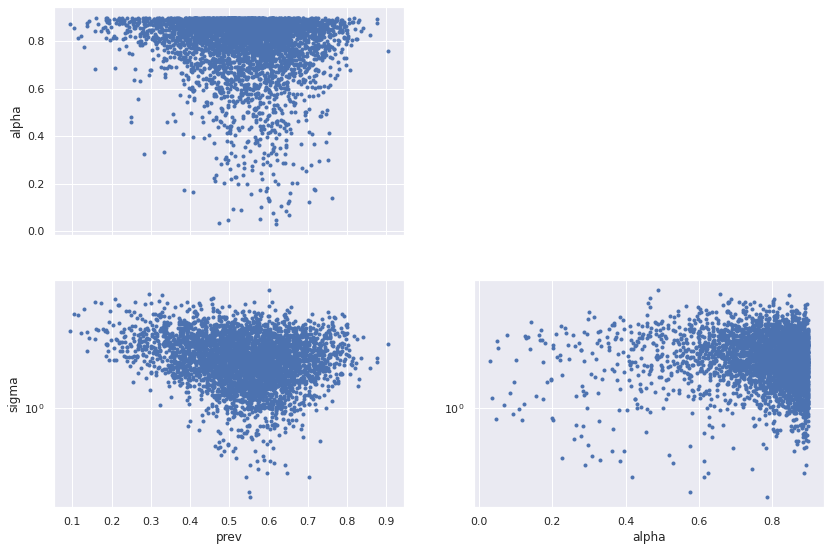

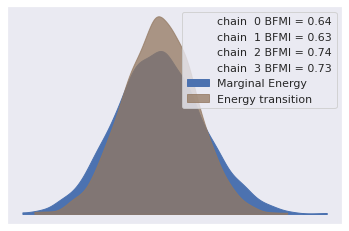

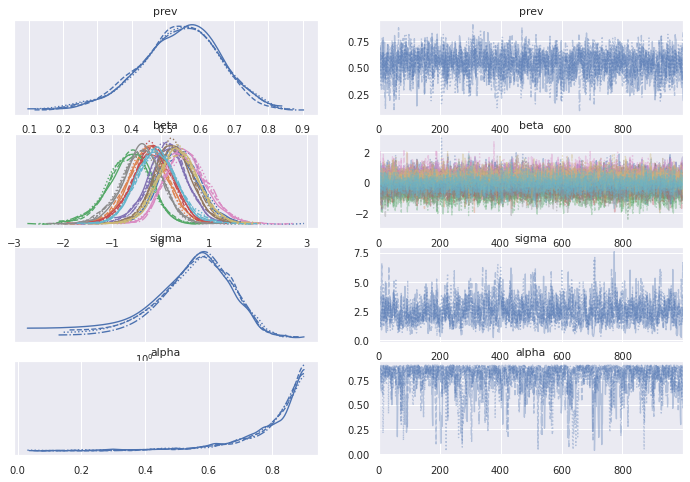

In [10]:
inference_data = az.convert_to_inference_data(fit5)
ax = az.plot_pair(inference_data, var_names=('prev', 'alpha', 'sigma'), 
                  divergences=True, group = 'posterior')
ax[1,0].set_yscale('log')
ax[1,1].set_yscale('log')
plt.show()

az.plot_energy(fit5)
plt.show()

ax = az.plot_trace(fit5, var_names=('prev', 'beta', 'sigma', 'alpha'))
ax[2,0].set_xscale('log')
plt.show()

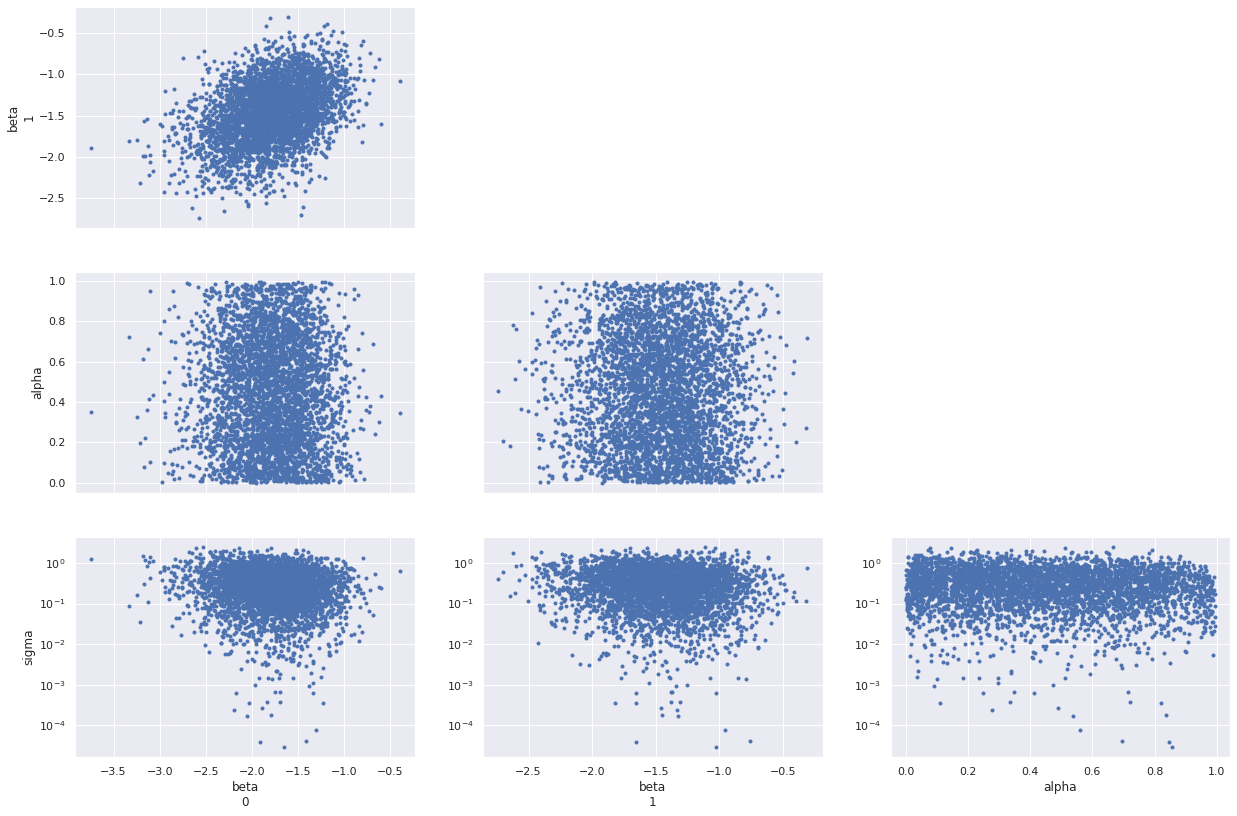

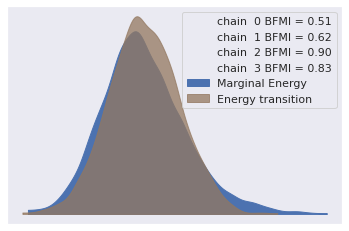

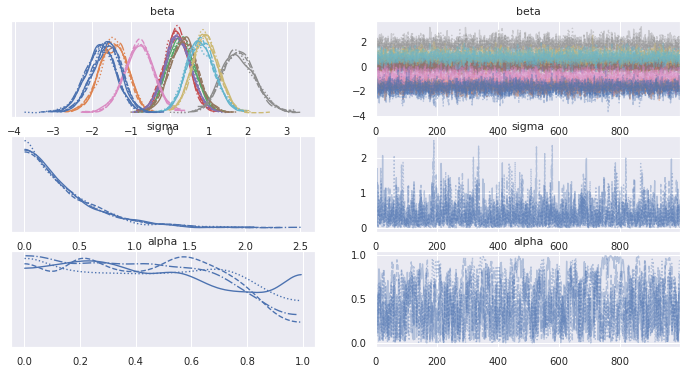

In [70]:
inference_data = az.convert_to_inference_data(fit6)
ax = az.plot_pair(inference_data, var_names=('beta', 'alpha', 'sigma'),
                  coords={'beta_dim_0': [0,1]},
                  divergences=True, group = 'posterior')
ax[2,0].set_yscale('log')
ax[2,1].set_yscale('log')
ax[2,2].set_yscale('log')
plt.show()

az.plot_energy(fit6)
plt.show()

ax = az.plot_trace(fit6, var_names=('beta', 'sigma', 'alpha'))
plt.show()

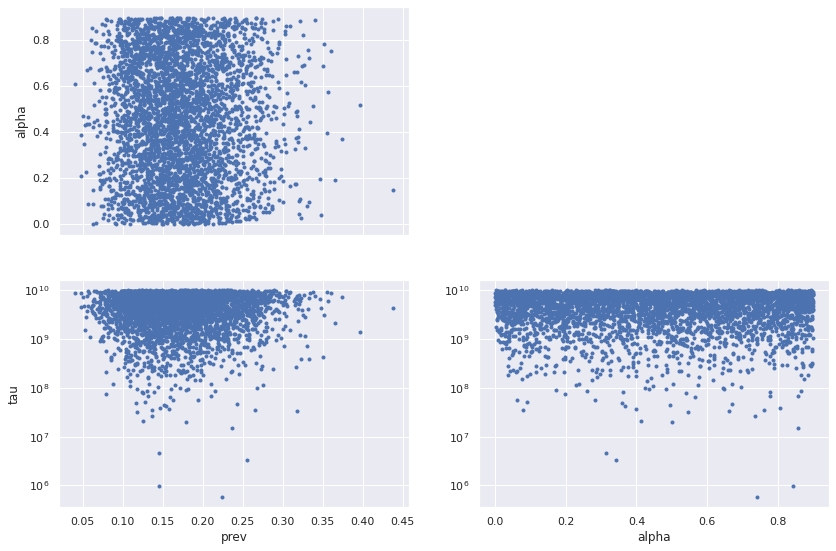

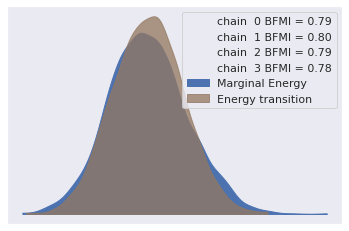

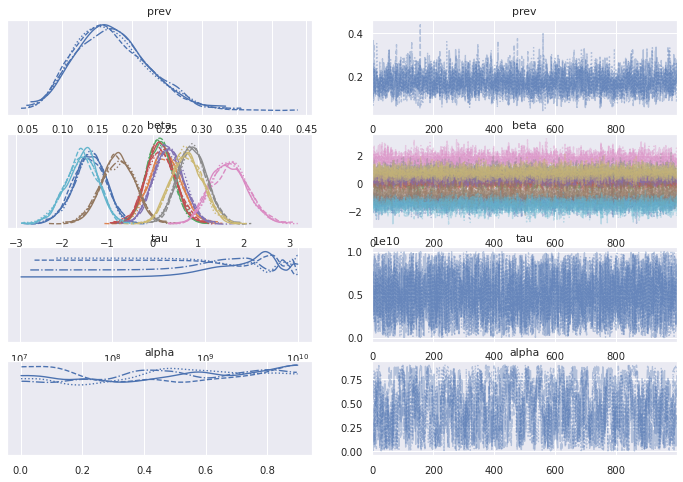

In [71]:
inference_data = az.convert_to_inference_data(fit8)
ax = az.plot_pair(inference_data, var_names=('prev', 'alpha', 'tau'), 
                  divergences=True, group = 'posterior')
ax[1,0].set_yscale('log')
ax[1,1].set_yscale('log')
plt.show()

az.plot_energy(fit8)
plt.show()

ax = az.plot_trace(fit8, var_names=('prev', 'beta', 'tau', 'alpha'))
ax[2,0].set_xscale('log')
plt.show()

In [72]:
n = 500
p = 10

X = np.random.multivariate_normal(mean = np.zeros(p+1),
                                  cov = np.eye(p+1), 
                                  size = n)
X = (X - X.mean(axis = 0))/X.std(axis = 0)
X[:,0] = 1

#W = nx.adjacency_matrix(nx.generators.trees.random_tree(n = n)).toarray()
W = nx.adjacency_matrix(nx.random_graphs.erdos_renyi_graph(n = n, p = 1/n)).toarray()
for i in range(n):
    if sum(W[i,:]) == 0:
        j = np.random.choice([k for k in range(n) if k != i])
        W[i,j] = 1
        W[j,i] = 1
        
W_n = W.sum() // 2
D = np.diag(W.sum(axis = 1))

rho = 0.5
tau = 1
prev  = 0.2
beta = np.array([logit(prev), -1.5, 0.4, 1, 0, 0.3, -0.8, 2, 0.9, 1.3, -1.93])

phi = np.random.multivariate_normal(mean = np.zeros(n), 
                                    cov = (1/tau) * np.linalg.inv(D - rho * W))

y = np.random.binomial(n = 1, p = expit(phi + X @ beta))
#y = np.random.poisson(np.exp(logit(prev) + phi + log_offset))

mu_beta = np.zeros(p+1)
mu_beta[0] = -2.7

cov_beta = np.eye(p+1)
cov_beta[0,0] = 1.3
    
data5 = {
    "n": n,
    "p": p,
    "X": X[:,1:],
    "y": y,
    "W": W,
    "W_n": W_n,
    "mu_beta": mu_beta[1:],
    "cov_beta": cov_beta[1:,1:],
    "alpha_tau": 0.01,
    "beta_tau": 0.01,
    "alpha_prev": 1,
    "beta_prev": 4,
    "lambda_tau": np.log(10),
    "gumbel_prior": 1,
    "M_tau": 1e10
}

data6 = {
    "n": n,
    "p": p,
    "X": X,
    "y": y,
    "W": W,
    "W_n": W_n,
    "mu_beta": mu_beta,
    "cov_beta": cov_beta,
    "alpha_tau": 0.01,
    "beta_tau": 0.01,
    "lambda_tau": np.log(10),
    "gumbel_prior": 1,
}

In [ ]:
%%time
fit5 = sm5.sampling(data=data5, 
                   control = {'adapt_delta': 0.85}, 
                   warmup=2500,
                   iter = 4000
                  )
summary5_500 = az.summary(fit5)

In [74]:
%%time
fit6 = sm6.sampling(data=data6, 
                   control = {'adapt_delta': 0.85}, 
                   #iter = 4000
                  )
summary6_500 = az.summary(fit6)

CPU times: user 4.94 s, sys: 113 ms, total: 5.05 s
Wall time: 35.1 s


In [75]:
%%time
data5['gumbel_prior'] = 0
fit8 = sm8.sampling(data=data5, 
                   control = {'adapt_delta': 0.85}, 
                   #iter = 4000
                  )
summary8_500 = az.summary(fit8)

CPU times: user 4.82 s, sys: 108 ms, total: 4.93 s
Wall time: 29.6 s


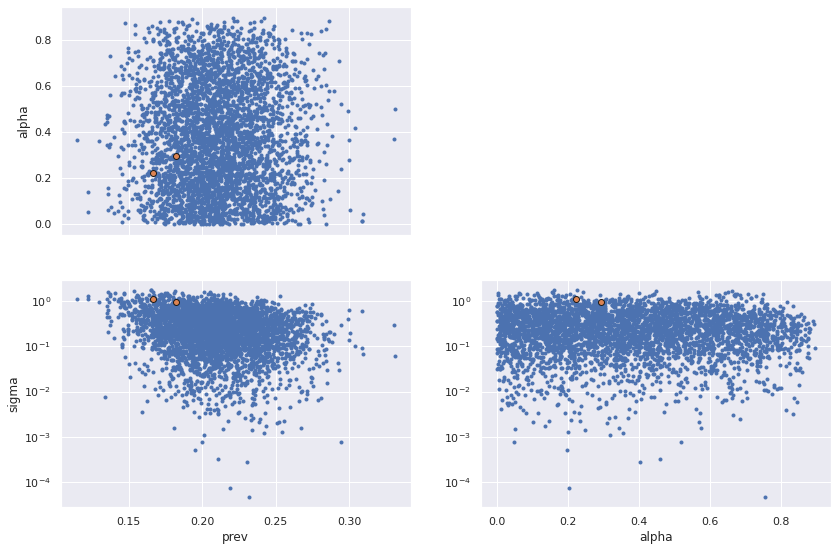

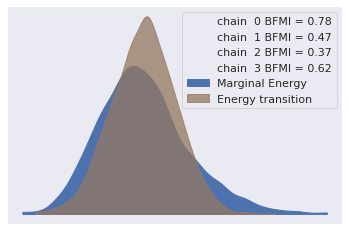

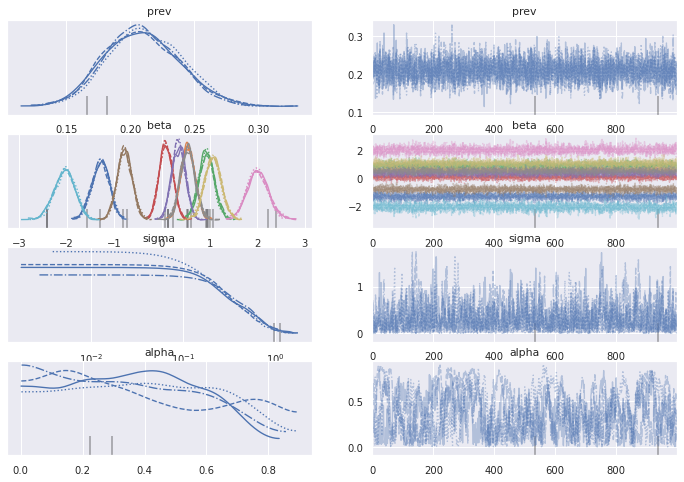

In [76]:
inference_data = az.convert_to_inference_data(fit5)
ax = az.plot_pair(inference_data, var_names=('prev', 'alpha', 'sigma'), 
                  divergences=True, group = 'posterior')
ax[1,0].set_yscale('log')
ax[1,1].set_yscale('log')
plt.show()

az.plot_energy(fit5)
plt.show()

ax = az.plot_trace(fit5, var_names=('prev', 'beta', 'sigma', 'alpha'))
ax[2,0].set_xscale('log')
plt.show()

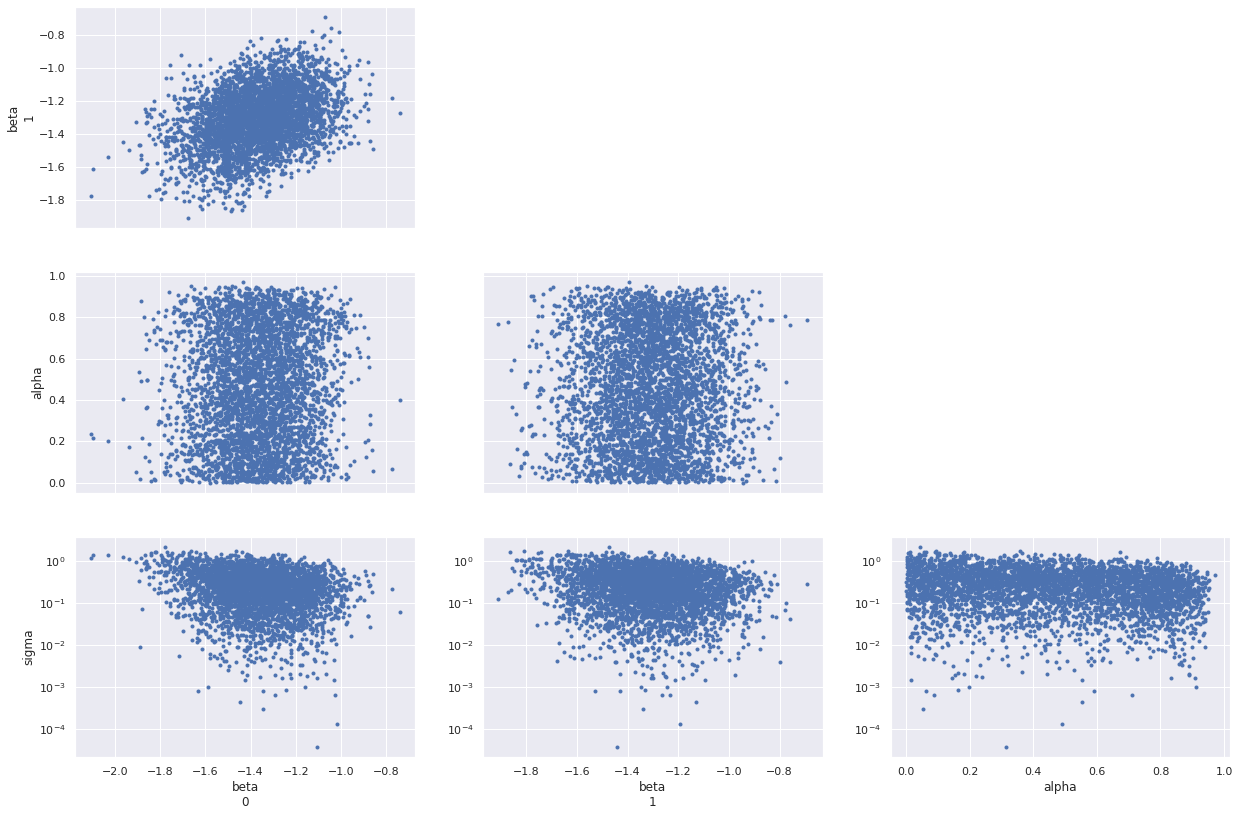

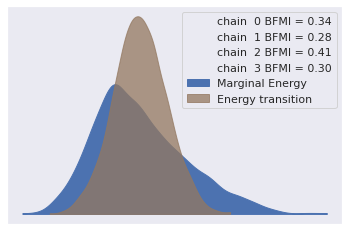

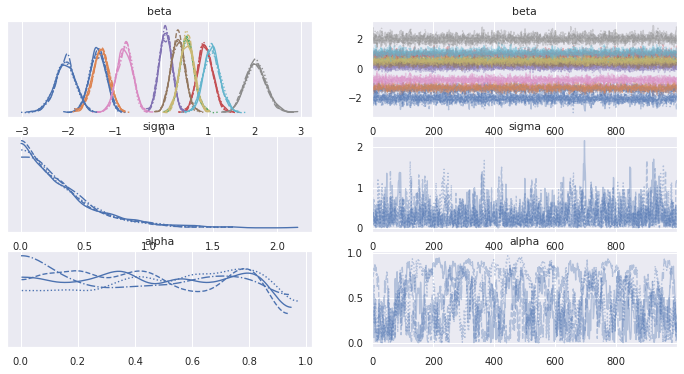

In [77]:
inference_data = az.convert_to_inference_data(fit6)
ax = az.plot_pair(inference_data, var_names=('beta', 'alpha', 'sigma'),
                  coords={'beta_dim_0': [0,1]},
                  divergences=True, group = 'posterior')
ax[2,0].set_yscale('log')
ax[2,1].set_yscale('log')
ax[2,2].set_yscale('log')
plt.show()

az.plot_energy(fit6)
plt.show()

ax = az.plot_trace(fit6, var_names=('beta', 'sigma', 'alpha'))
plt.show()

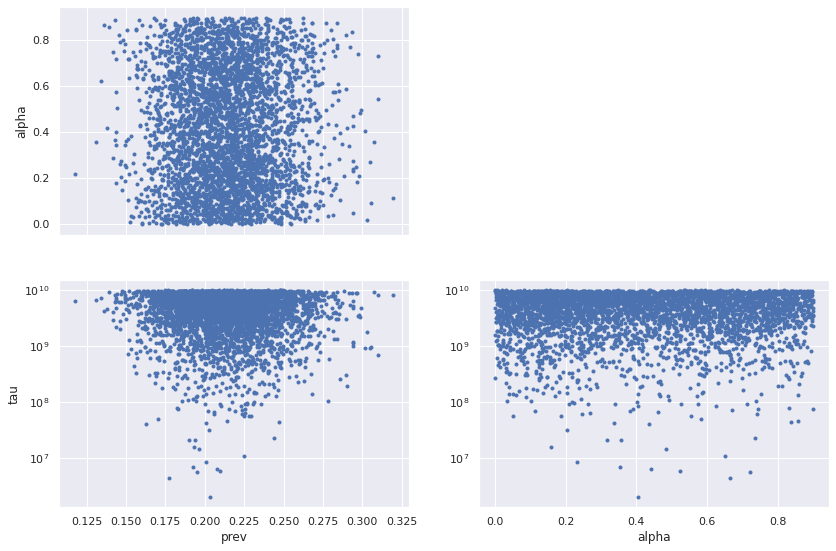

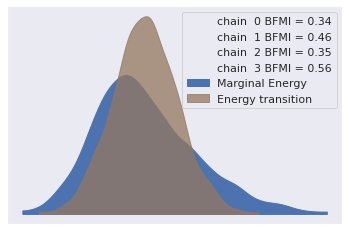

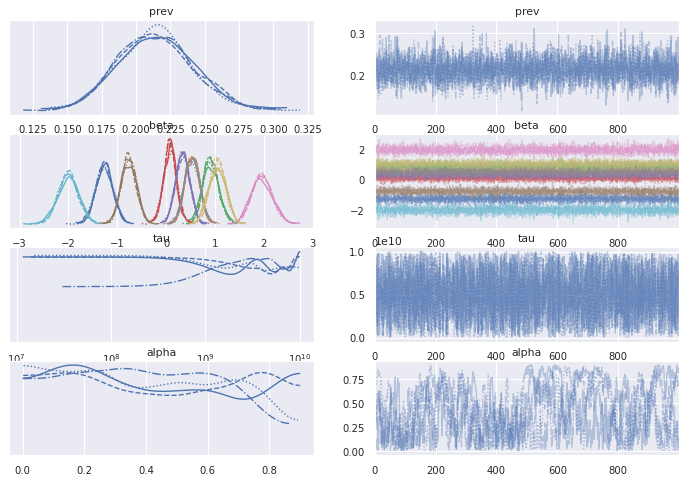

In [78]:
inference_data = az.convert_to_inference_data(fit8)
ax = az.plot_pair(inference_data, var_names=('prev', 'alpha', 'tau'), 
                  divergences=True, group = 'posterior')
ax[1,0].set_yscale('log')
ax[1,1].set_yscale('log')
plt.show()

az.plot_energy(fit8)
plt.show()

ax = az.plot_trace(fit8, var_names=('prev', 'beta', 'tau', 'alpha'))
ax[2,0].set_xscale('log')
plt.show()

In [133]:
def plotting_alphas(m2_list, rho_list):  
    
    n= 1000
    m1 = np.linspace(1/n,1,n,endpoint=False)
    v1 = np.linspace(1/n,0.3,n,endpoint=False)
    x,y = np.meshgrid(m1,v1)

    tilde_alpha = lambda m1,m2,v1: (m1 - m1*m1 - v1)/v1
    alpha1 = lambda m1,m2,v1,rho: (m1 + m2 - 1) * tilde_alpha(m1,m2,v1) + alpha4(m1,m2,v1,rho)
    alpha2 = lambda m1,m2,v1,rho: (1 - m2) * tilde_alpha(m1,m2,v1) - alpha4(m1,m2,v1,rho)
    alpha3 = lambda m1,m2,v1,rho: (1 - m1) * tilde_alpha(m1,m2,v1) - alpha4(m1,m2,v1,rho)
    alpha4 = lambda m1,m2,v1,rho:  rho * tilde_alpha(m1,m2,v1) * np.sqrt(m1 * m2 *(1-m1) * (1-m2)) \
                                   + (1-m1) * (1-m2)

    z = lambda m1,m2,v1,rho: 1*(alpha1(m1,m2,v1,rho) > 0)\
                              *(alpha2(m1,m2,v1,rho) > 0)\
                              *(alpha3(m1,m2,v1,rho) > 0)\
                              *(alpha4(m1,m2,v1,rho) > 0)\
                              *(v1 < m1 - m1**2) +  2*(v1 >= m1 - m1**2)
    
    fig, ax = plt.subplots(5,4,figsize = (15,10), sharex = True , sharey = True)
    #fig.suptitle(r'Fixing $m_2$ = {} and $\rho$ = {}'.format(m2,rho))
    for k in range(20): 

        i = k // 4
        j = k % 4
        
        m2 = m2_list[k]
        rho = rho_list[k]

        ax[i,j].contourf(x,y,z(x,m2,y,rho), levels = [0, 0.5, 1], colors = ['#fdcdac', '#cbd5e8'])
        ax[i,j].set_title(r'$m_2$ = {} and $\rho$ = {}'.format(m2,rho), fontsize = 12)
        ax[i,j].plot(m1, m1 - m1**2, linestyle = '--', color = 'black')
        
    for i in range(4): 
        ax[4,i].set_xlabel(r'$m_1$', fontsize = 15)
        ax[i,0].set_ylabel(r'$v_1$', fontsize = 15)
    ax[4,0].set_ylabel(r'$v_1$', fontsize = 15)
        
    ax[0,0].legend(handles = [mpatches.Patch(color='#fdcdac', label=r'$\alpha >\not  0$'.format(k+1)),
                              mpatches.Patch(color='#cbd5e8', label=r'$\alpha > 0$'.format(k+1))])
    
    plt.show()

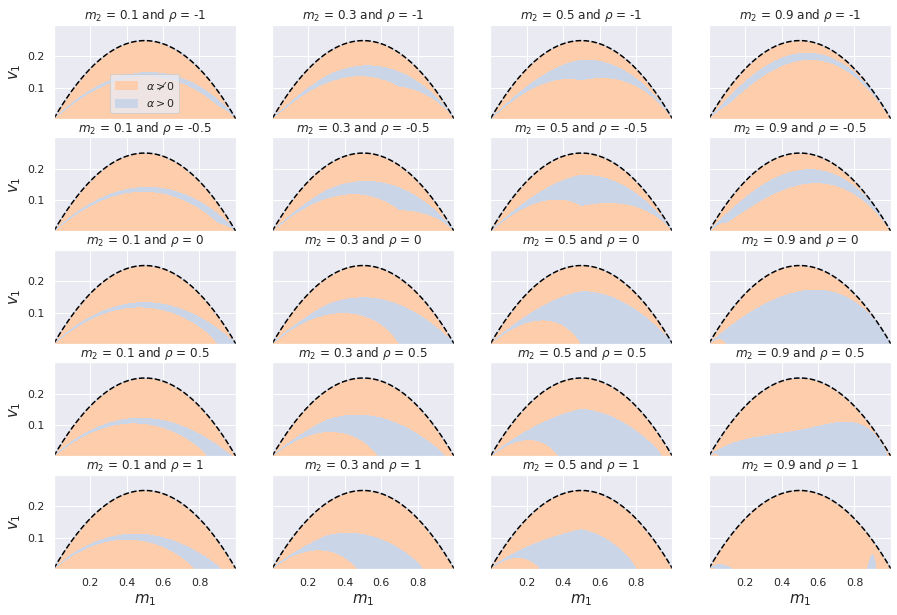

In [134]:
plotting_alphas([0.1, 0.3, 0.5, 0.9]*5, 
                [-1]*4 + [-0.5]*4 + [0]*4 + [0.5]*4 + [1]*4)

In [214]:
def plotting_alphas(v1_list, rho_list):  
    
    n= 2000
    m2 = np.linspace(1/n,1,n,endpoint=False)

    tilde_alpha = lambda m1,m2,v1: (m1 - m1*m1 - v1)/v1
    alpha1 = lambda m1,m2,v1,rho: (m1 + m2 - 1) * tilde_alpha(m1,m2,v1) + alpha4(m1,m2,v1,rho)
    alpha2 = lambda m1,m2,v1,rho: (1 - m2) * tilde_alpha(m1,m2,v1) - alpha4(m1,m2,v1,rho)
    alpha3 = lambda m1,m2,v1,rho: (1 - m1) * tilde_alpha(m1,m2,v1) - alpha4(m1,m2,v1,rho)
    alpha4 = lambda m1,m2,v1,rho:  rho * tilde_alpha(m1,m2,v1) * np.sqrt(m1 * m2 *(1-m1) * (1-m2)) \
                                   + (1-m1) * (1-m2)

    z = lambda m1,m2,v1,rho: 1*(alpha1(m1,m2,v1,rho) > 0)\
                              *(alpha2(m1,m2,v1,rho) > 0)\
                              *(alpha3(m1,m2,v1,rho) > 0)\
                              *(alpha4(m1,m2,v1,rho) > 0)
    
    fig, ax = plt.subplots(3,5,figsize = (16,7), sharex = True, sharey = True)
    #fig.suptitle(r'Fixing $m_2$ = {} and $\rho$ = {}'.format(m2,rho))
    for k in range(15): 

        i = k // 5
        j = k % 5
        
        v1 = v1_list[k]
        rho = rho_list[k]
        
        m1 = np.linspace((1 - np.sqrt(1-4*v1))/2,(1 + np.sqrt(1-4*v1))/2,n, endpoint=False)
        x,y = np.meshgrid(m1,m2)

        ax[i,j].contourf(x,y,z(x,y,v1,rho), levels = [0, 0.5, 1], colors = ['#A84C43', '#54A874'])
        ax[i,j].set_title(r'$v_1$ = {} and $\rho$ = {}'.format(v1,rho), fontsize = 12)
        #ax[i,j].plot(m1, m1 - m1**2, linestyle = '--', color = 'black')
        
    for i in range(3): 
        ax[2,i].set_xlabel(r'$m_1$', fontsize = 15)
        ax[i,0].set_ylabel(r'$m_2$', fontsize = 15)
    ax[2,3].set_xlabel(r'$m_1$', fontsize = 15)
    ax[2,4].set_xlabel(r'$m_1$', fontsize = 15)
        
    fig.legend(handles = [mpatches.Patch(color='#A84C43', label=r'$\alpha_i < 0$ for some $i$'.format(k+1)),
                          mpatches.Patch(color='#54A874', label=r'$\alpha_1, \dots, \alpha_4 > 0$'.format(k+1))], 
               loc = 'lower right')

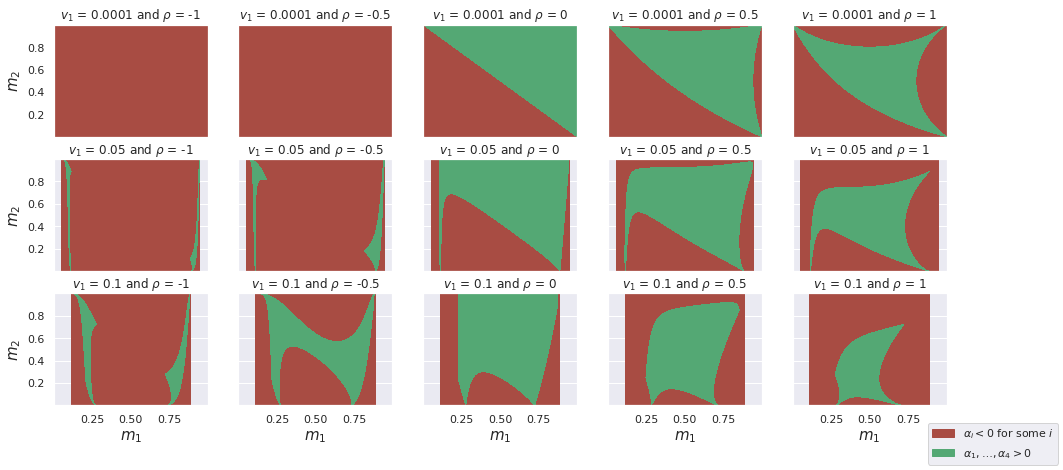

In [216]:
plotting_alphas([0.0001]*5 + [0.05]*5 + [0.1]*5, 
                [-1, -0.5, 0, 0.5, 1]*4)
plt.savefig('../images/alpha_solution_existence.eps', bbox_inches = 'tight', format = 'eps')